In [1]:
from ipynb.fs.full.utility_functions import gen_toy_data, get_cumsum, get_mean, get_T, plot_sequence, lopart

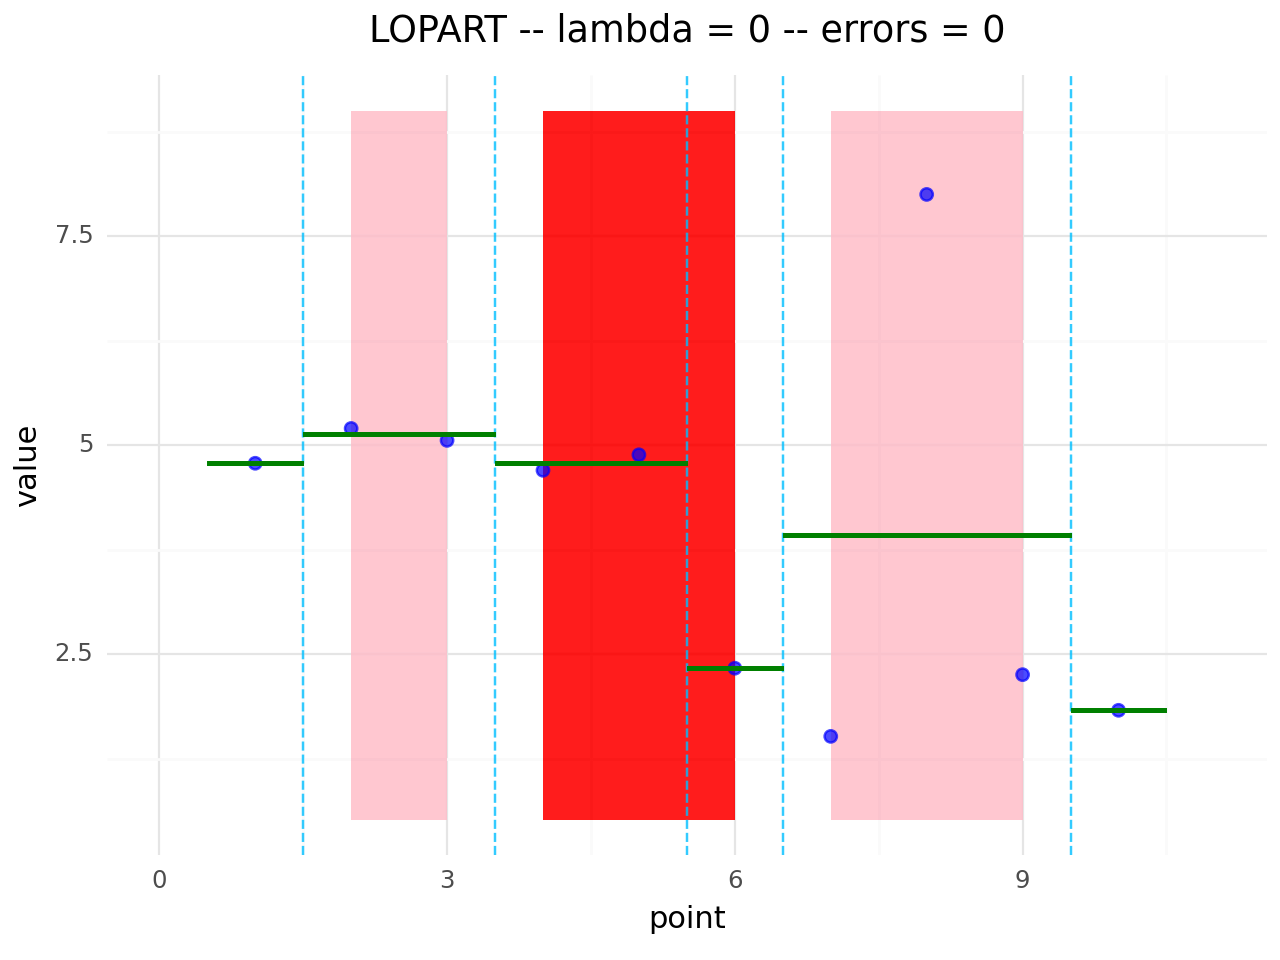

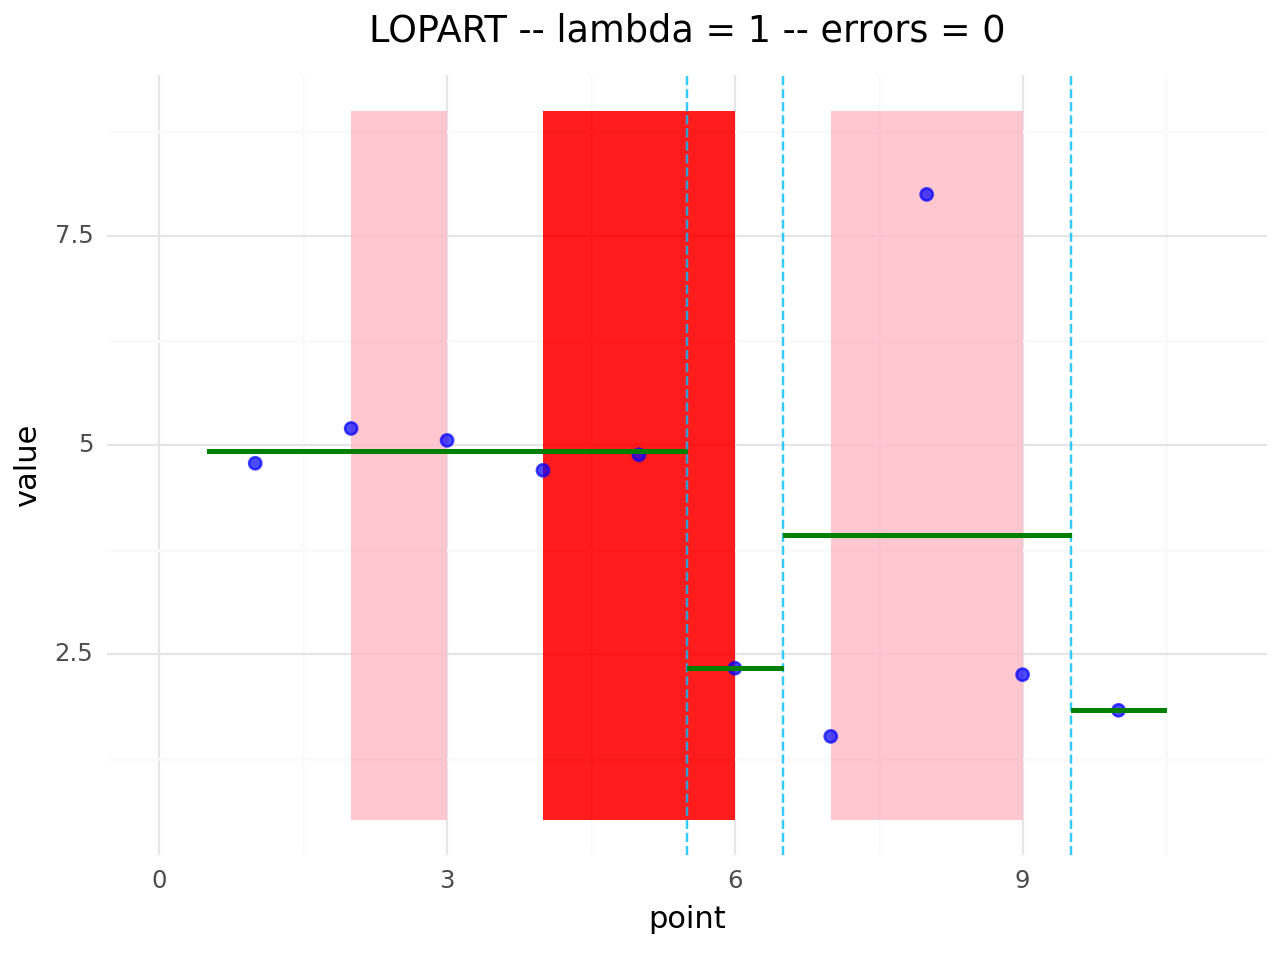

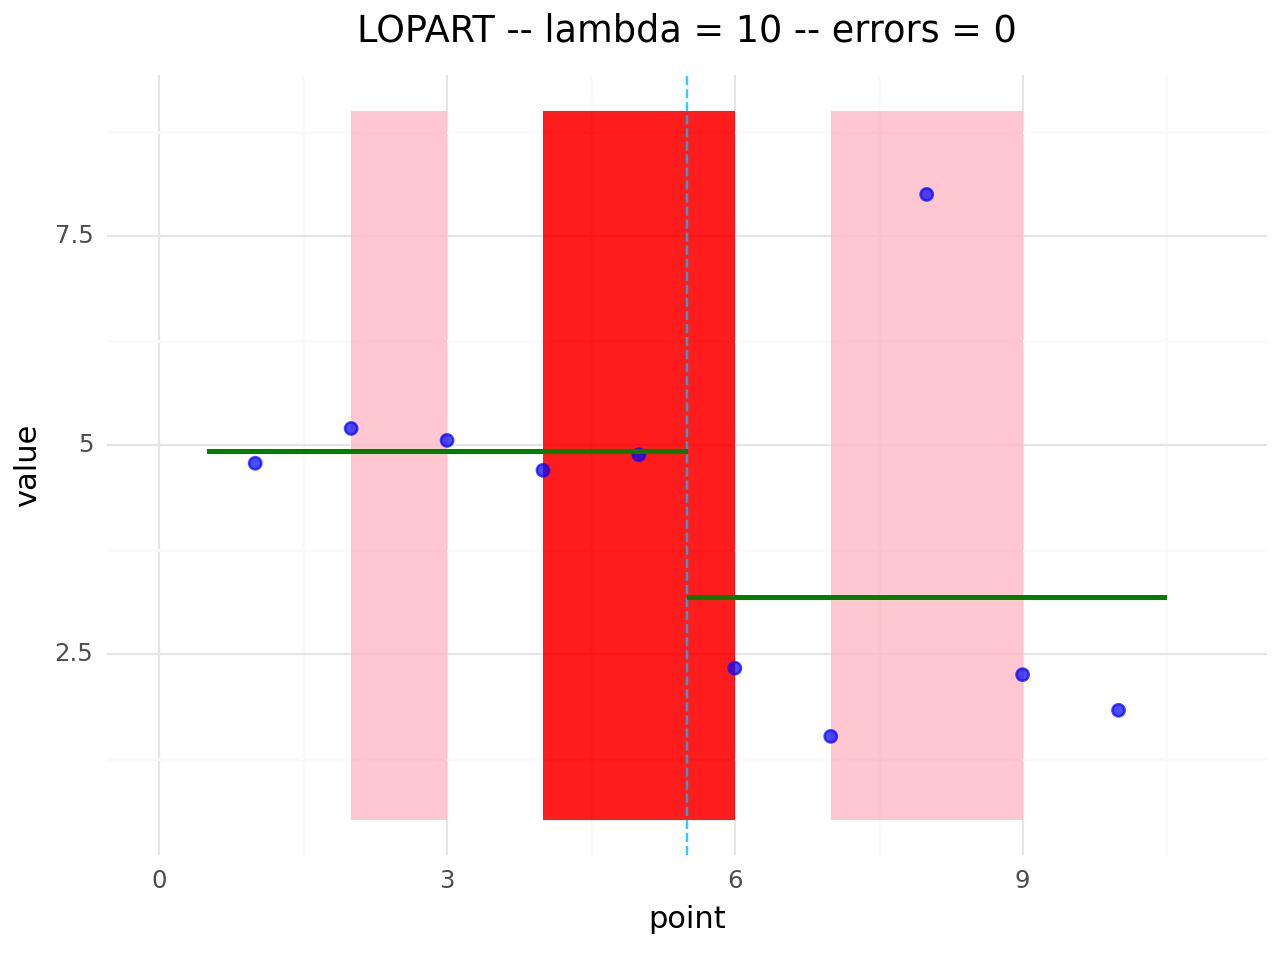

In [2]:
# generate data
sequence, neg_start, neg_end, pos_start, pos_end = gen_toy_data()
sequence_length = len(sequence) - 1

for lda in [0, 1, 10]:
    chpnt = lopart(sequence, neg_start, neg_end, pos_start, pos_end, lda)
    print(plot_sequence(sequence, neg_start, neg_end, pos_start, pos_end, 'LOPART', chpnt, lda))